In [1]:
!pip install shap gym stable-baselines3[extra] > /dev/null 2>&1

The system cannot find the path specified.


In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import shap
import pickle

from sklearn.preprocessing import MinMaxScaler
from stable_baselines3 import PPO
from stable_baselines3.common.policies import obs_as_tensor
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

In [3]:
train_og = pd.read_csv("/notebooks/ProcessedDataset/top001_train.csv")
test_og = pd.read_csv("/notebooks/ProcessedDataset/top001_test.csv")

train_enc = pd.read_csv("/notebooks/FinalDataset/top001_train_encoded.csv")
test_enc = pd.read_csv("/notebooks/FinalDataset/top001_test_encoded.csv")

x_train = train_enc.drop('attack_cat', axis=1)
y_train = train_enc['attack_cat']

x_train_og = train_og.drop('attack_cat', axis=1)
y_train_og = train_og['attack_cat']

x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_train_og, y_train_og = shuffle(x_train_og, y_train_og, random_state=42)

model = PPO.load("/notebooks/Models/RL/RL_001_Balanced.zip", device="cpu")

target_names = ["Analysis", "Backdoors", "DoS", "Exploits", "Fuzzers", 
                "Generic", "Reconnaissance", "Shellcode", "Worms"]

FileNotFoundError: [Errno 2] No such file or directory: './ProcessedDataset/top001_train.csv'

In [4]:
def rl_prediction(state):
    obs = obs_as_tensor(state, model.policy.device)
    dis = model.policy.get_distribution(obs)
    probs = dis.distribution.probs
    probs_np = probs.detach().numpy()
    return probs_np 
    res, _ = model.predict(state, deterministic=True)
    return res

with open("/notebooks/Utils/SHAP_explainer.pkl", "rb") as file:
    SHAP_explainer = pickle.load(file)
    
nsamples = 5_000
x_samples = pd.read_csv(f"/notebooks/Utils/x_samples_{nsamples}.csv")
y_samples = pd.read_csv(f"/notebooks/Utils/y_samples_{nsamples}.csv")

with open(f"/notebooks/Utils/shap_values_{nsamples}.pkl", "rb") as file:
    shap_values = pickle.load(file)

## Disaggregated class features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


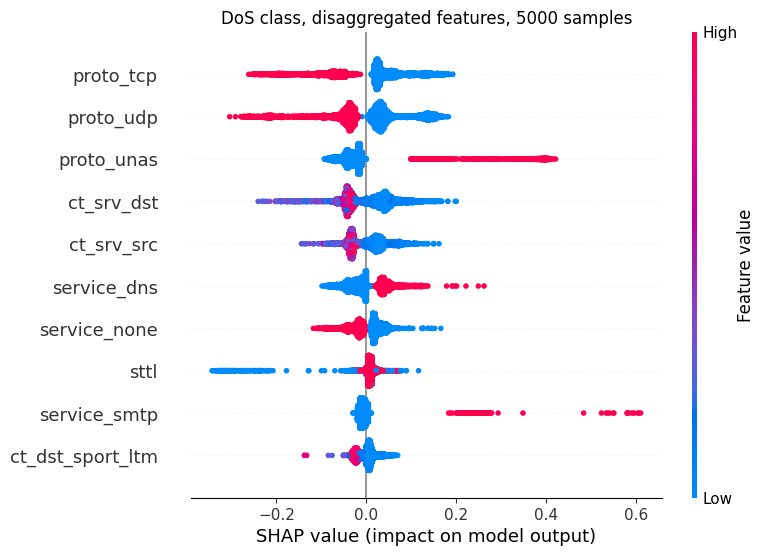

In [5]:
target_class = "DoS"

target_class_i = target_names.index(target_class)
plt.figure()
shap.summary_plot(shap_values[target_class_i],
                  x_samples,
                  max_display=10,
                  plot_type="dot",
                  show=False)
plt.title(f"{target_names[target_class_i]} class, disaggregated features, {nsamples} samples")
plt.show()

## Numerical column avg shap_value by range

In [19]:
target_feature = 'ct_srv_dst'
n_intervals = 1000

intervals = np.linspace(x_train[target_feature].min(), x_train[target_feature].max(), n_intervals)
intervals_og = np.linspace(x_train_og[target_feature].min(), x_train_og[target_feature].max(), n_intervals)

feature_values = x_samples[[target_feature]]

avg_shap_arr = []

for i in range(len(intervals)-1):
    mask = (feature_values[:] >= intervals[i]) & (feature_values[:] < intervals[i+1])
    data_slice = shap_values[target_class_i][mask[target_feature].values, x_samples.columns.tolist().index(target_feature)]
    avg_shap = np.nanmean(data_slice) if len(data_slice) > 0 else 0
    avg_shap_arr.append(avg_shap)
    if (avg_shap != 0.00):
        print(f'{intervals_og[i]:.2f} <= {target_feature} < {intervals_og[i+1]:.2f}: {avg_shap:.4f}')

1.00 <= ct_srv_dst < 1.06: 0.0479
1.98 <= ct_srv_dst < 2.04: 0.0396
2.95 <= ct_srv_dst < 3.02: 0.0475
3.99 <= ct_srv_dst < 4.05: 0.0423
4.97 <= ct_srv_dst < 5.03: 0.0376
5.95 <= ct_srv_dst < 6.01: 0.0110
6.98 <= ct_srv_dst < 7.05: -0.0334
7.96 <= ct_srv_dst < 8.02: -0.0606
9.00 <= ct_srv_dst < 9.06: -0.0818
9.98 <= ct_srv_dst < 10.04: -0.0639
10.95 <= ct_srv_dst < 11.01: -0.0859
11.99 <= ct_srv_dst < 12.05: -0.1022
12.97 <= ct_srv_dst < 13.03: -0.0763
13.94 <= ct_srv_dst < 14.01: -0.0740
14.98 <= ct_srv_dst < 15.04: -0.0739
15.96 <= ct_srv_dst < 16.02: -0.0518
17.00 <= ct_srv_dst < 17.06: -0.0477
17.97 <= ct_srv_dst < 18.04: -0.0486
18.95 <= ct_srv_dst < 19.01: -0.0461
19.99 <= ct_srv_dst < 20.05: -0.0469
20.97 <= ct_srv_dst < 21.03: -0.0484
21.94 <= ct_srv_dst < 22.01: -0.0441
22.98 <= ct_srv_dst < 23.04: -0.0464
23.96 <= ct_srv_dst < 24.02: -0.0458
25.00 <= ct_srv_dst < 25.06: -0.0420
25.97 <= ct_srv_dst < 26.04: -0.0425
26.95 <= ct_srv_dst < 27.01: -0.0431
27.99 <= ct_srv_dst < 28.0

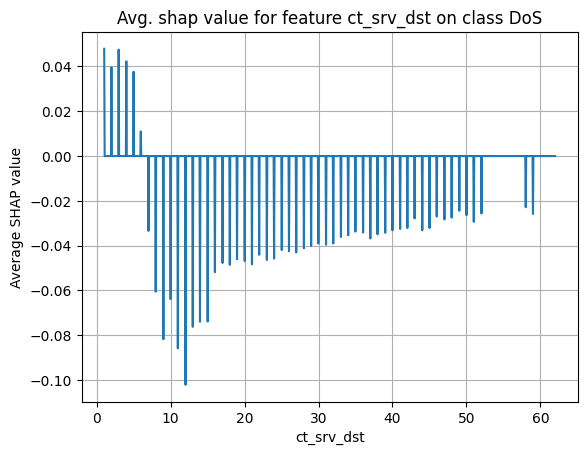

In [20]:
xticks = np.linspace(x_train_og[target_feature].min(), x_train_og[target_feature].max(), n_intervals-1)
plt.plot(xticks, avg_shap_arr)
plt.title(f"Avg. shap value for feature {target_feature} on class {target_class}")
plt.xlabel(f"{target_feature}")
plt.ylabel(f"Average SHAP value")
plt.grid()
plt.show()

## Numerical column avg shap_value by given value

In [22]:
n_intervals = 11
target_feature = 'ct_srv_dst'
test_value = lambda x: (x >= 0) & (x <= 7)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x_train_og[[target_feature]])

feature_values = scaler.inverse_transform(x_samples[[target_feature]])
feature_values = pd.DataFrame({target_feature : feature_values.flatten()})

mask = (test_value(feature_values[:]))

data_slice = shap_values[target_class_i][mask[target_feature].values, x_samples.columns.tolist().index(target_feature)]
avg_shap = np.nanmean(data_slice) if len(data_slice) > 0 else 0
print(f'Number of shap background samples that meet the condition: {len(data_slice)}')
print(f'Avg. shap value for {target_feature} values under a condition: {avg_shap:.4f}')

Number of shap background samples that meet the condition: 2836
Avg. shap value for ct_srv_dst values under a condition: 0.0426


## Categorical/binary column avg shape value

In [9]:
target_feature = 'proto_unas'

feature_values = x_samples[[target_feature]]

for i in range(2):
    mask = feature_values[:] == i
    data_slice = shap_values[target_class_i][mask[target_feature].values, x_samples.columns.tolist().index(target_feature)]
    avg_shap = np.nanmean(data_slice) if len(data_slice) > 0 else 0
    print(f'{target_feature} on {i}: {avg_shap:.4f}')

proto_unas on 0: -0.0343
proto_unas on 1: 0.3127
